In [19]:
import requests
from pyproj import Proj
import matplotlib.pyplot as plt
from math import log10, floor, ceil
import numpy as np
from scipy.interpolate import interp2d
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
def getFietspaals():
    URL = "https://api.data.amsterdam.nl/v1/fietspaaltjes/fietspaaltjes/"
    myReturnArray = []
    page = 1;
    result = requests.get(URL).json()
    for fietspaal in extract(result):
        myReturnArray.append(fietspaal)
    print(f'page: {page} - poles: {len(myReturnArray)}')
    while 'next' in result['_links'].keys():
        result = requests.get(result['_links']['next']['href']).json()
        for fietspaal in extract(result):
            myReturnArray.append(fietspaal)
        page += 1
        print(f'page: {page} - poles: {len(myReturnArray)}')
    return myReturnArray

def extract(fietspaaltJson):
    myReturnArray = []
    for fietspaal in fietspaaltJson['_embedded']['fietspaaltjes']:
        myReturnArray.append(fietspaal)
    return myReturnArray

In [3]:
# conversionMethod = Proj("EPSG:28992", inverse = True)
def convert(json):
     coordinates = json['geometry']['coordinates']
     return [coordinates[1], coordinates[0]]
    # return conversionMethod(123207.66039241236, 486624.64005186077)

def roundToXDigits(num, x, up):
     rounder = x-int(floor(log10(abs(num))))-1
     addNumber = 10 ** (-(rounder)) / 2
     return round(num + addNumber if up else num - addNumber, rounder)

In [4]:
fietspaals = getFietspaals()

page: 1 - poles: 20
page: 2 - poles: 40
page: 3 - poles: 60
page: 4 - poles: 80
page: 5 - poles: 100
page: 6 - poles: 120
page: 7 - poles: 140
page: 8 - poles: 160
page: 9 - poles: 180
page: 10 - poles: 200
page: 11 - poles: 220
page: 12 - poles: 240
page: 13 - poles: 260
page: 14 - poles: 280
page: 15 - poles: 300
page: 16 - poles: 320
page: 17 - poles: 340
page: 18 - poles: 360
page: 19 - poles: 380
page: 20 - poles: 400
page: 21 - poles: 420
page: 22 - poles: 440
page: 23 - poles: 460
page: 24 - poles: 480
page: 25 - poles: 500
page: 26 - poles: 520
page: 27 - poles: 540
page: 28 - poles: 560
page: 29 - poles: 580
page: 30 - poles: 600
page: 31 - poles: 620
page: 32 - poles: 640
page: 33 - poles: 660
page: 34 - poles: 680
page: 35 - poles: 700
page: 36 - poles: 720
page: 37 - poles: 740
page: 38 - poles: 760
page: 39 - poles: 780
page: 40 - poles: 800
page: 41 - poles: 820
page: 42 - poles: 840
page: 43 - poles: 860
page: 44 - poles: 880
page: 45 - poles: 900
page: 46 - poles: 920
p

In [29]:
bigNum = 999_999_999_999
lowestX = bigNum
lowestY = bigNum
highestX = -bigNum
highestY = -bigNum
bikePoles = []
x_coords = []
y_coords = []
values = []
scores = []

for fietspaal in fietspaals:
    try:
        myBikePole = {
            "coordinates": convert(fietspaal),
            "count": int(fietspaal["count"]) if fietspaal['count'] != None else 0,
            "score": fietspaal['scoreCurrent']
        }
        bikePoles.append(myBikePole)
        myX = myBikePole["coordinates"][1]
        myY = myBikePole["coordinates"][0]
        myCount = myBikePole["count"]
        if myX > highestX:
            highestX = myX
        elif myX < lowestX:
            lowestX = myX
        if myY > highestY:
            highestY = myY
        elif myY < lowestY:
            lowestY = myY
        x_coords.append(myX)
        y_coords.append(myY)
        values.append(myBikePole["count"])
        scores.append(myBikePole['score'])
    except:
        print(f'bikepole at {fietspaal["street"]}-{fietspaal["at"]} ignored as it does not have coordinates: {fietspaal}')

lowestX = roundToXDigits(lowestX, 2, False)
highestX = roundToXDigits(highestX, 2, True)
lowestY = roundToXDigits(lowestY, 2, False)
highestY = roundToXDigits(highestY, 2, True)

bikepole at Entrepotdok-220 ignored as it does not have coordinates: {'_links': {'schema': 'https://schemas.data.amsterdam.nl/datasets/fietspaaltjes/dataset#fietspaaltjes', 'self': {'href': 'https://api.data.amsterdam.nl/v1/fietspaaltjes/fietspaaltjes/CE-1005-2019/', 'title': 'CE-1005-2019', 'id': 'CE-1005-2019'}}, 'id': 'CE-1005-2019', 'geometry': None, 'street': 'Entrepotdok', 'at': '220', 'area': 'Amsterdam-Centrum', 'score2013': None, 'scoreCurrent': 'slecht', 'count': 6, 'paaltjesWeg': ['nu paaltje(s)'], 'soortPaaltje': ['paaltje(s) ong. 75cm hoog'], 'uiterlijk': ['rood/wit'], 'type': ['uitneembaar'], 'ruimte': ['Voldoende: 1,6m of meer'], 'markering': ['onvoldoende markering'], 'beschadigingen': ['paal scheef, voet steekt uit', 'schade paal/reflectie: krassen, roest, verbleking'], 'veiligheid': ['vrij moeilijke locatie'], 'zichtInDonker': ['lampje op paal zelf'], 'soortWeg': None, 'noodzaak': ['nodig tegen sluipverkeer']}
bikepole at Javakade-Seranggracht ignored as it does not h

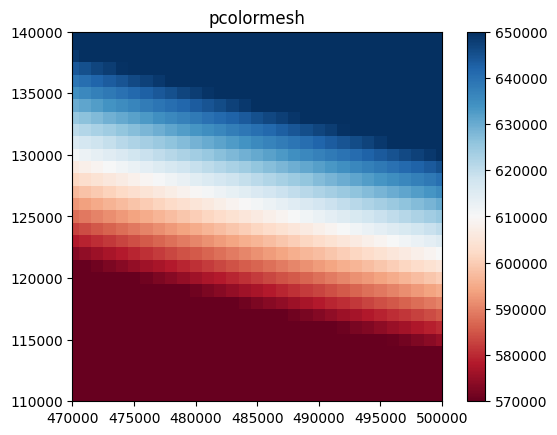

In [64]:
def plot(interpol):
    fig, ax = plt.subplots()

    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=570_000, vmax=650_000)
    ax.set_title('pcolormesh')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)

    plt.imshow(z, cmap='RdBu', interpolation = interpol)
plot('bilinear')

C:\Users\Amelia\AppData\Local\Temp\ipykernel_17156\3658059327.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  valFunc = interp2d(np.array(x_coords), np.array(y_coords), np.array(values), kind="linear", fill_value=0)
C:\Users\Amelia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\interpolate\_interpolate.py:286: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable cause

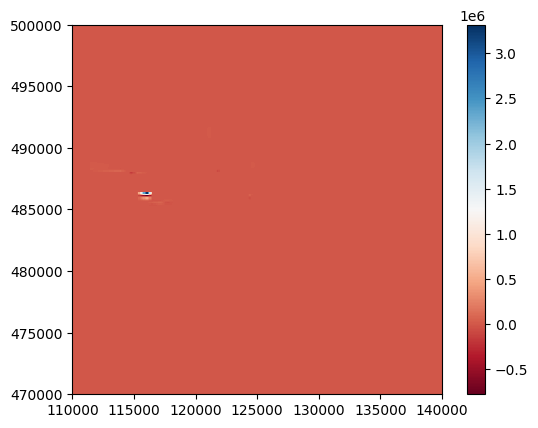

In [25]:
y, x = np.arange(lowestY, highestY +1, 100), np.arange(lowestX, highestX + 1, 100)
valFunc = interp2d(np.array(x_coords), np.array(y_coords), np.array(values), kind="linear", fill_value=0)


vals = valFunc(np.array(x), np.array(y))
fig = plt.imshow(
    vals,
    extent=[lowestX, highestX, lowestY, highestY],
    origin="lower",
    interpolation="none",
    interpolation_stage='rgba',
    norm="linear",
    # vmin=0,vmax=5_000,
    cmap='RdBu'
)
plt.colorbar()

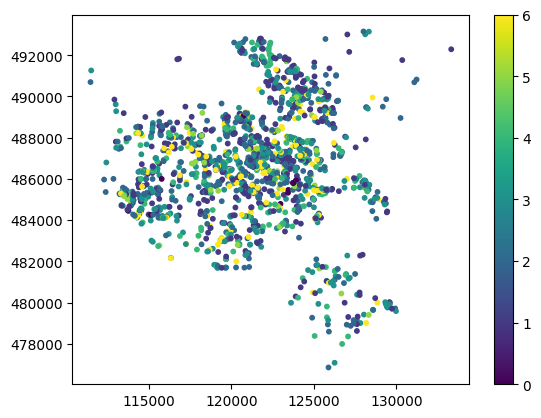

In [31]:
plt.scatter(x_coords, y_coords, c=values, s=10)
plt.colorbar()
plt.show()

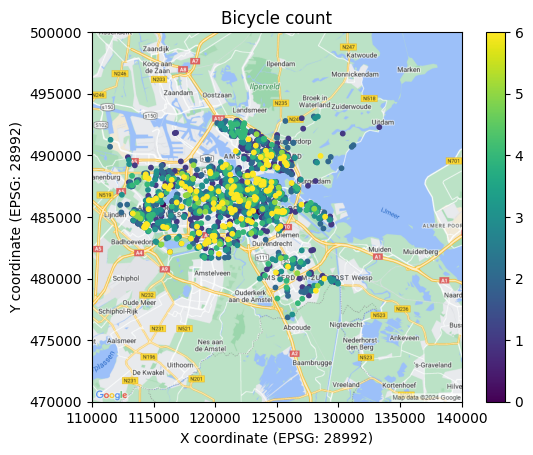

In [51]:
df = pd.DataFrame(data={'x': x_coords, 'y': y_coords, 'z': values})
df.sort_values('z', inplace=True)
plt.scatter(df['x'], df['y'], c=df['z'], s=10, zorder=1)
plt.colorbar()
plt.title("Bicycle count")
plt.xlabel("X coordinate (EPSG: 28992)")
plt.ylabel("Y coordinate (EPSG: 28992)")
plt.imshow(plt.imread("amsterdam.png"), zorder=0, extent=[lowestX, highestX, lowestY, highestY])
plt.show()